## Overview  
The below Natural Language Processing Model is an assignment from an [Udemy Machine Learning class](https://www.udemy.com/course/python-for-data-science-and-machine-learning-bootcamp/?utm_source=adwords&utm_medium=udemyads&utm_campaign=Python_v.PROF_la.EN_cc.US_ti.7380&utm_content=deal4584&utm_term=_._ag_78513466559_._ad_436603254913_._kw__._de_c_._dm__._pl__._ti_dsa-774930046209_._li_9030072_._pd__._&matchtype=b&gclid=Cj0KCQiA9P__BRC0ARIsAEZ6iriN81oGE4RLs6f0zCpoBHxAbJNchYTEvzNHU9QE-cNlYdKRtxqLnAAaAkiaEALw_wcB)

## Problem Statement

Provided with the [SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) from the UCI Machine Learning Repository develop an NLP Model to identify spam messages.

## Additional NLP Resources

[NLTK Book Online](http://www.nltk.org/book/)

[Kaggle Walkthrough](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words)

[SciKit Learn's Tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

## Table of Contents  

* [Import Libraries](#import_libraries)
* [Import Data](#import_data)
* [Create DataFrame and Descriptive Metrics](#create_dataframe)
* [Data Preprocessing; check for nulls](#data_preprocessing)
* [Exploratory Data Analysis](#explore_data)
* [Text Pre-processing](#txt_preproc)
* [Vectorization](#vectorization)
* [Create and Train the Model](#train_model)
* [Model Evaluation](#model_eval)
* [Splitting the data into training and testing sets](#split_data)
* [Create Data Pipeline](#pipeline)
* [Export Prediction File](#export)
* [Evaluation Metrics](#eval_metrics)

<a class="anchor" id="import_libraries"></a>
## Import Libraries

In [1]:
import nltk 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [81]:
#Can view list of available packages within NLTK, via .download_shell(), 'l' (List)
#Can specify package to download  via .download_shell(), 'd' (Download)

#nltk.download_shell()

<a class="anchor" id="import_data"></a>
## Import Data

Data for this project is saved in a folder 'smsspamcollection' in our current working director

Import text as a list

In [2]:
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]
print(len(messages))

5574


Enumerate through the first 10 messages and print:

In [3]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim cod

Due to the spacing we can tell that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself. (Note our numbers aren't part of the file, they are just from the **enumerate** call).

Using these labeled ham and spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

From the official SciKit Learn documentation, we can visualize our process:

<a class="anchor" id="create_dataframe"></a>
## Create DataFrame and Descriptive Metrics

Use pandas to import and parse the TSV file:

In [5]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 43.6+ KB


In [8]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [9]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general.

Let's make a new column to detect how long the text messages are:

In [11]:
messages['length']=messages['message'].apply(len)

In [12]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


<a class="anchor" id="data_preprocessing"></a>
## Data Preprocessing; check for nulls  

In [13]:
messages.isnull().sum()

label      0
message    0
length     0
dtype: int64

<a class="anchor" id="explore_data"></a>
## Exploratory Data Analysis

Understanding the relationship between the feature attributes and the target variable

In [51]:
#sns.pairplot(df)

<AxesSubplot:xlabel='length', ylabel='Count'>

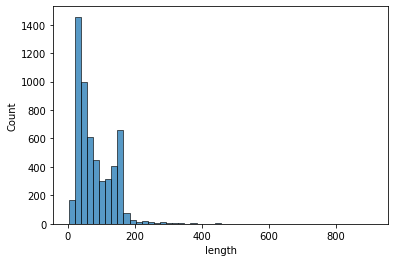

In [83]:
sns.histplot(messages['length'],bins=50)

There appears to be one/few messages that are really long

In [17]:
messages['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

The longest messge in the document is 910 characters long

In [22]:
#retrieve the row from the 'message'  feature from the occurence where the 'length' == 910
messages[messages['length']==910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Can we determine if 'length' is an informative attribute of a message being spam? 

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

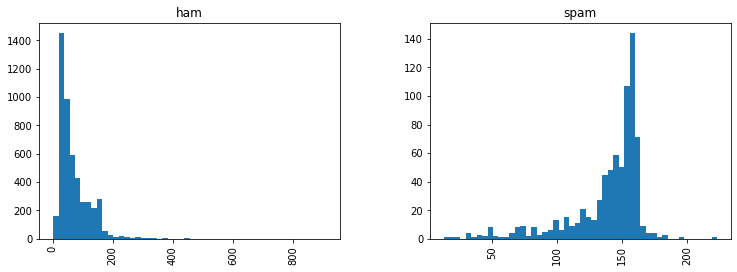

In [24]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

**Based on the histogram plots of 'legth' by label, it appears that spam messages tend to be longer**

<a class="anchor" id="txt_preproc"></a>
## Text Pre-processing

Pre-processing is the step of transforming your text into a form that is predictable and analyzable for your task. A task is the combination of approach and domain. For example, extracting top keywords with TF-IDF (approach) from Tweets (domain) is an example of a Task.

**Appropriate Pre-Processing steps depend on the Task (approach & domain), and may not be directly transferrable/approppriate between tasks.**



[Notebook of examples Lowercasing, Stemming, Lemmatization, Stop Word Removal, Noise Removal](https://github.com/kavgan/nlp-in-practice/blob/master/text-pre-processing/Text%20Preprocessing%20Examples.ipynb) ()

[Notebook of examples Noise Removal, Tokenization, Normalization](https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html)


[NLTK book online](http://www.nltk.org/book/)


[Examples of pre-processing techiniques include](https://www.kdnuggets.com/2019/04/text-preprocessing-nlp-machine-learning.html):  

### Must Do:
  **Noise Removal**: Removing characters, digits and pieces of text that can interfere with your text analysis. Can include punctuation removal, special character removal, numbers removal, html formatting removal, domain specific keyword removal (e.g. ‘RT’ for retweet), source code removal, header removal and more. 
  
  **Lowercasing**: Lowercasing ALL your text data  
 
### Should Do:

  **Normalization**: Text normalization is the process of transforming a text into a standard form [a series of related tasks]. For example, the word “gooood” and “gud” can be transformed to “good”. Another example is mapping of near identical words such as “stopwords”, “stop-words” and “stop words” to just “stopwords”. This is especially important for noisy texts such as social media comments, text messages and comments to blog posts where abbreviations, misspellings and use of out-of-vocabulary words (oov) are prevalent.  

### Can Do:
  [**Stemming**](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html): Stemming is the process of reducing inflection in words (e.g. troubled, troubles) to their root form (e.g. trouble).   
  
  [**Lemmatization**](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html): Similar to stemming, lemmatization removes inflections and map words to its root form. However, instead of just trimming off the end of words like stemming, Lemmatization actually transforms words to the actual root. For example, the word “better” would map to “good”.  
  
  **Stop words**: remove commonly used words  
  
  **Tokenization**: is a step which splits longer strings of text into smaller pieces, or tokens. 
  
  **Text Enrichment / Augmentation**: involves augmenting your original text data with information that you did not previously have. Text enrichment provides more semantics to your original text, thereby improving its predictive power and the depth of analysis you can perform on your data. You can use [part-of-speech tagging](https://en.wikipedia.org/wiki/Part-of-speech_tagging) to get more granular information about the words in your text. For example, in a document classification problem, the appearance of the word **book** as a **noun** could result in a different classification than **book** as a **verb** as one is used in the context of reading and the other is used in the context of reserving something. You could also  use [embeddings](https://en.wikipedia.org/wiki/Word_embedding) to enrich the meaning of words, phrases and sentences for classification, search, summarization and text generation in general. Other text enrichment techniques include [phrase extraction](http://kavita-ganesan.com/how-to-incorporate-phrases-into-word2vec-a-text-mining-approach/#.YBF3L-hKiUl), where you recognize compound words as one (aka chunking), [expansion with synonyms](https://www.aclweb.org/anthology/R09-1073/) and [dependency parsing](http://www.cs.virginia.edu/~kc2wc/teaching/NLP16/slides/15-DP.pdf).
  

We need to convert our string data (sequence of characters) into a format consumable by algorithims (feature vectors (sequences of numbers)). To do this we'll use the Bag of Words approach;  and take following pre-processing steps:

1) Noise Removal (punctuation); use **string** library  
2) Remove Stop Words; use **NLTK** library  
3) Write a function that will split a message into its individual words and return a list. 

Example of **NOISE REMOVAL** (punctuation):

In [29]:
#this yields a string (nopunc) with punctuation removed 

import string

mess = 'Sample message! Notice: it has punctuation.'

#Check individual characters to see if they are in string.punctuation, if they are NOT, then keep/append to new variable (nopunc)
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters back together to form the string.
nopunc = ''.join(nopunc)

In [31]:
#nopunc

'Sample message Notice it has punctuation'

Example of **STOP WORD REMOVAL**:

In [62]:
#import 'english' stopwords from nltk.corpus
from nltk.corpus import stopwords

In [66]:
# of stopwords
#len(stopwords.words('english'))

In [67]:
#example of stopwords
#stopwords.words('english')[0:10]

In [70]:
#Use a split string that has had punctuation removed; ex/nopunc.split()
#compare lower case items in the split string (word.lower()) with words contained in stopwords.words('english'); if the split string word is NOT in stopwords.words('english'), then append to new variable (clean_mess)
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [71]:
#String before removing stop words:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [72]:
#String after removing stop words:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

Lower case the 'message' feature:

In [91]:
messages['message']=messages['message'].apply(lambda x: x.lower())

Create Function of Pre-processing Steps; to apply to our DataFrame

In [94]:
def punc_and_stop_removal(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
      
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [95]:
#check to make sure the funtion is working; only use a few rows of data to test (.head())
messages['message'].head(10).apply(punc_and_stop_removal)

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
5    [freemsg, hey, darling, 3, weeks, word, back, ...
6    [even, brother, like, speak, treat, like, aids...
7    [per, request, melle, melle, oru, minnaminungi...
8    [winner, valued, network, customer, selected, ...
9    [mobile, 11, months, u, r, entitled, update, l...
Name: message, dtype: object

<a class="anchor" id="vectorization"></a>
## Vectorization

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as **term frequency**)

2. Weigh the counts, so that frequent tokens get lower weight (**inverse document frequency**)

3. *Normalize* the vectors to unit length, to abstract from the original text length (**L2 norm**)


Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [96]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function: punc_and_stop_removal

In [98]:
#bag of words_transformer is fit to messages['message'] data 
bow_transformer = CountVectorizer(analyzer=punc_and_stop_removal).fit(messages['message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

9540


We can compare a message from the document with its BOW vector with  `bow_transformer`:

In [99]:
message4 = messages['message'][3]
print('Message format:')
print(message4)

Message format:
u dun say so early hor... u c already then say...


In [102]:
#use bow_transformer on 1 message (message4), defined above
bow4 = bow_transformer.transform([message4])
print('Vector representation:')
print(bow4)
print('\n')
print('Vector shape:')
print(bow4.shape)

Vector representation:
  (0, 1129)	1
  (0, 1910)	1
  (0, 3003)	1
  (0, 3024)	1
  (0, 4221)	1
  (0, 7215)	2
  (0, 8633)	2


Vector shape:
(1, 9540)


Based on the Vector representation, this message has 7 unique words, 2 of which were used multiple times (2x)

In [103]:
#We can retrieve the word at a given vector position using .get_feature_names
print(bow_transformer.get_feature_names()[7215])
print(bow_transformer.get_feature_names()[8633])

say
u


### Transform Entire 'messages' feature

In [104]:
messages_bow = bow_transformer.transform(messages['message'])

In [105]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 9540)
Amount of Non-Zero occurences:  50346


In [106]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

____
### TF-IDF: a measure of how important a word is to a document in a collection or corpus
TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
____

In [110]:
from sklearn.feature_extraction.text import TfidfTransformer

#an instance of TfidfTransformer fit to the 'messages' vectors/bag of words: messages_bow
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 8633)	0.31949158769666564
  (0, 7215)	0.5597000940482765
  (0, 4221)	0.46452762500729494
  (0, 3024)	0.33557436526898854
  (0, 3003)	0.30912546538910485
  (0, 1910)	0.2870370340589675
  (0, 1129)	0.27985004702413824


Example of how to check the IDF (inverse document frequency) of a specific word ("u" and "university"):

In [109]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

2.932365119299588
8.239394426449646


Transform the entire bag-of-words corpus into TF-IDF corpus:

In [111]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 9540)


<a class="anchor" id="train_model"></a>
## Create and Train the Model

With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [112]:
from sklearn.naive_bayes import MultinomialNB

In [115]:
#fit an instance of the MultinomialNB classifier to messages_tfidf
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

Let's try classifying our single random message and checking how we do:

In [116]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


<a class="anchor" id="model_eval"></a>
## Model Evaluation

Now we want to determine how well our model will do overall on the entire dataset

In [117]:
#First; retrieve all the predictions:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [118]:
from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      4825
        spam       1.00      0.83      0.91       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



# NOTE: So far we've built and trained model to the ENTIRE dataset, we need to split train/test data, and retrain and test model (along with performing all the same preprocessing/transformation steps); We can easily achieve this by building a PIPELINE

<a class="anchor" id="split_data"></a>
## Splitting the data into training and testing sets

Split data into train and test sets

In [120]:
from sklearn.model_selection import train_test_split

In [121]:
X_train, X_test, y_train, y_test = train_test_split(messages['message'], messages['label'], test_size=0.2)

<a class="anchor" id="pipeline"></a>
## Create Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. 

This will **allow us to set up all the transformations** that we will do to the data for future use.

In [123]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=punc_and_stop_removal)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [124]:
#fit pipeline 'model' to training data
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function punc_and_stop_removal at 0x174066F0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [131]:
#create predictions of test data
predictions = pipeline.predict(X_test)

<a class="anchor" id="export"></a>
## Export Prediction File

Convert 'predictions' array into pd DataFrame

In [146]:
final_dataset = pd.DataFrame(
    {
        "label": predictions,
    },
    index = X_test.index
)

In [154]:
final_dataset.head()

,label
5317,ham
2499,ham
4942,ham
2904,ham
947,spam


In [152]:
export_pred = pd.DataFrame(data=final_dataset,
                             columns=['label'],
                             index=X_test.index)

In [153]:
export_pred.to_csv('submission.csv')

<a class="anchor" id="eval_metrics"></a>
## Evaluation Metrics

In [127]:
#create evaluation metric using the predictions from the test data (predictions), and the actual test labels (y_test)
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.97      1014
        spam       0.66      1.00      0.79       101

    accuracy                           0.95      1115
   macro avg       0.83      0.97      0.88      1115
weighted avg       0.97      0.95      0.96      1115

